In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import random
import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
from rdkit import Chem
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, auc
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor, MolSurf
from rdkit.Chem.Draw import rdMolDraw2D, MolToFile, _moltoimg
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

number of all smiles:  2050
failed to process smiles:  O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
failed to process smiles:  c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC
failed to process smiles:  Cc1nc(sc1)\[NH]=C(\N)N
failed to process smiles:  s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N
failed to process smiles:  c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1ccccc1
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
failed to process smiles:  s1cc(nc1\[NH]=C(\N)N)C
failed to process smiles:  c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC
number of successfully processed smiles:  2039


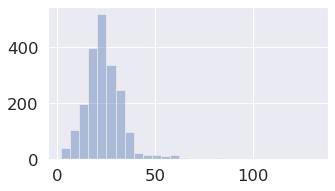

In [4]:
task_name = 'BBBP'
tasks = ['BBBP']
raw_filename = "../data/BBBP.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("failed to process smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2
weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
remained_df = remained_df.reset_index(drop=True)
uncovered_df

,BBBP,smiles,cano_smiles
944,0,CC(C)C1OC(=O)C2=CCCN2C(=O)c3coc(CC(=O)CC(O)\C=...,C/C1=C/C(O)CC(=O)Cc2nc(co2)C(=O)N2CCC=C2C(=O)O...


In [7]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

class ScaffoldGenerator(object):
    """
    Generate molecular scaffolds.

    Parameters
    ----------
    include_chirality : : bool, optional (default False)
      Include chirality in scaffolds.
    """

    def __init__(self, include_chirality=False):
        self.include_chirality = include_chirality

    def get_scaffold(self, mol):
        """
        Get Murcko scaffolds for molecules.

        Murcko scaffolds are described in DOI: 10.1021/jm9602928. They are
        essentially that part of the molecule consisting of rings and the
        linker atoms between them.

        Parameters
        ----------
        mols : array_like
            Molecules.
        """
        return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=self.include_chirality)


def generate_scaffold(smiles, include_chirality=False):
    mol = Chem.MolFromSmiles(smiles)
    engine = ScaffoldGenerator(include_chirality=include_chirality)
    scaffold = engine.get_scaffold(mol)
    return scaffold


In [8]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])
    
scaffold_list = []
all_scaffolds_dict = {}

for index, smiles in enumerate(remained_df['cano_smiles']):
    scaffold = generate_scaffold(smiles)
    scaffold_list.append(scaffold)
    if scaffold not in all_scaffolds_dict:
        all_scaffolds_dict[scaffold] = [index]
    else:
        all_scaffolds_dict[scaffold].append(index)
remained_df['scaffold'] = scaffold_list


In [9]:
scaffold_list = list(remained_df.groupby(['scaffold'])['scaffold'].count() \
                     .reset_index(name='count') \
                     .sort_values(['count'], ascending=False) \
                     .scaffold)

In [10]:
def scaffold_randomized_spliting(scaffolds_dict, sample_size, random_seed = 0): 
    count = 0
    minor_count = 0
    minor_class = np.argmax(weights[0]) # weights are inverse of the ratio
    minor_ratio= 1/weights[0][minor_class]
    optimal_count = 0.1*len(remained_df)
    while (count < optimal_count*0.95 or  count > optimal_count*1.05) \
        or (minor_count < minor_ratio*optimal_count*0.95 \
            or  minor_count > minor_ratio*optimal_count*1.05):
        random_seed +=1
        random.seed(random_seed)
        scaffold = random.sample(list(scaffolds_dict.keys()), sample_size)
        count = sum([len(scaffolds_dict[scaffold]) for scaffold in scaffold])
        index = [index for scaffold in scaffold for index in scaffolds_dict[scaffold]]
        minor_count = len(remained_df.iloc[index, :][remained_df[tasks[0]] == minor_class])
#     print(random)
    print(random_seed, count, minor_count, index)
    return scaffold, index

samples_size = int(len(all_scaffolds_dict.keys())*0.1)
print(samples_size)
test_scaffold, test_index = scaffold_randomized_spliting(all_scaffolds_dict, samples_size, random_seed=0)
training_scaffolds_dict = {x: all_scaffolds_dict[x] for x in all_scaffolds_dict.keys() if x not in test_scaffold}
valid_scaffold, valid_index = scaffold_randomized_spliting(training_scaffolds_dict, samples_size, random_seed=0)


102
76 206 47 [739, 923, 1921, 779, 301, 1342, 1805, 1877, 1886, 524, 69, 119, 365, 609, 646, 1074, 1075, 1122, 1481, 838, 1630, 376, 477, 543, 1462, 1627, 882, 974, 993, 362, 113, 1612, 1885, 640, 1647, 544, 665, 709, 1163, 1408, 1776, 1788, 355, 636, 1540, 1834, 1047, 76, 86, 335, 337, 614, 616, 1686, 7, 1293, 824, 1161, 1785, 1186, 1534, 769, 1441, 372, 1084, 1085, 1722, 1880, 635, 1067, 1782, 913, 27, 80, 285, 289, 1597, 1300, 1235, 1837, 810, 219, 531, 681, 1927, 141, 1181, 394, 1245, 1874, 1497, 1266, 121, 1439, 1394, 526, 696, 2010, 1327, 1137, 151, 1685, 1423, 1012, 1902, 14, 470, 578, 708, 851, 946, 967, 1049, 1155, 1274, 1370, 1606, 1693, 1697, 1703, 1708, 1725, 1741, 1857, 1887, 1917, 22, 660, 320, 1560, 1598, 1789, 990, 1867, 252, 1193, 1422, 1463, 1470, 1173, 1740, 817, 868, 869, 894, 1070, 879, 272, 925, 965, 996, 1323, 1792, 1799, 10, 66, 93, 264, 308, 387, 388, 1119, 1275, 948, 970, 1134, 1225, 1229, 1230, 1303, 1615, 1625, 1706, 1821, 1823, 1958, 2006, 2008, 755, 1747,

/data2/erikxiong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


219 201 47 [1519, 1392, 748, 759, 762, 763, 1157, 61, 586, 618, 619, 620, 621, 720, 1547, 1579, 167, 493, 1424, 1495, 1629, 1809, 1701, 590, 968, 978, 1183, 1550, 1552, 1640, 1962, 1970, 1987, 747, 592, 1027, 2025, 211, 735, 792, 823, 83, 447, 707, 979, 1111, 2032, 2001, 969, 809, 1368, 215, 1578, 237, 677, 949, 1038, 1633, 1635, 1933, 207, 322, 1362, 59, 1563, 518, 607, 1614, 721, 731, 850, 888, 674, 1770, 1208, 109, 110, 648, 703, 1355, 1385, 1532, 1849, 1901, 1140, 1567, 161, 1835, 1069, 702, 1530, 1536, 1728, 1574, 813, 815, 713, 30, 193, 445, 448, 479, 496, 989, 1007, 1050, 1347, 1492, 1577, 1699, 1710, 1909, 1990, 2021, 2022, 1798, 74, 783, 784, 785, 16, 546, 197, 1938, 664, 1098, 1165, 933, 1405, 1783, 1911, 1192, 180, 65, 658, 797, 805, 927, 139, 1145, 1203, 1804, 1878, 1984, 123, 1670, 999, 826, 1976, 1410, 1876, 1993, 1572, 1384, 774, 263, 1295, 1992, 192, 573, 1723, 883, 1430, 1802, 827, 1761, 1978, 1652, 26, 1529, 1668, 17, 124, 257, 994, 1682, 397, 1417, 1413, 1170, 2004, 

In [11]:
%matplotlib inline
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [193]:
remained_df[remained_df['scaffold'] == scaffold_list[9]]['BBBP'].value_counts()

1    12
0     4
Name: BBBP, dtype: int64

In [189]:
remained_df['BBBP'].value_counts()

1    1560
0     475
Name: BBBP, dtype: int64

,BBBP,cano_smiles,ROMol
488,1,CC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@@H](CN2CCCC2)C1,
490,1,COC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@@H](CN2CCCC2)C1,
507,1,CCOC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@@H](CN2CCCC2)C1,
508,1,CCCOC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@@H](CN2CCCC2)C1,
510,0,CC(=O)N1CCN(C(=O)Cc2ccc(Cl)c(Cl)c2)[C@@H](CN2CC[C@@H](O)C2)C1,
511,0,CC(=O)N1CCN(C(=O)Cc2ccc(C(F)(F)F)cc2)[C@@H](CN2CC[C@@H](O)C2)C1,
512,0,CSc1ccc(CC(=O)N2CCN(C(C)=O)C[C@@H]2CN2CC[C@@H](O)C2)cc1,
513,0,CC(=O)N1CCN(C(=O)Cc2cc(F)cc(F)c2)[C@@H](CN2CC[C@@H](O)C2)C1,
514,0,COc1cccc(CC(=O)N2CCN(C(C)=O)C[C@@H]2CN2CC[C@@H](O)C2)c1,
515,0,CC(=O)N1CCN(C(=O)Cc2ccc([N+](=O)[O-])cc2)[C@@H](CN2CC[C@H](O)C2)C1,

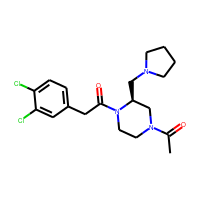
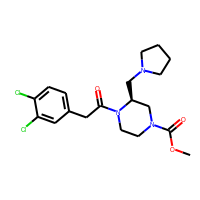
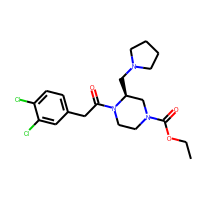
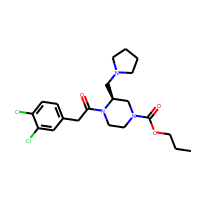
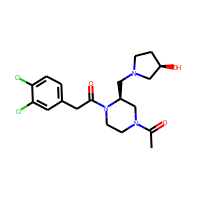
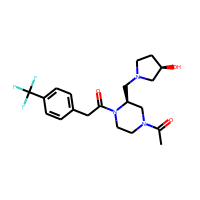
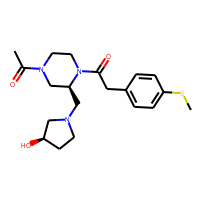
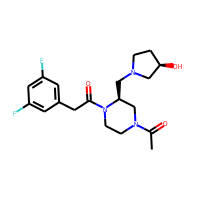
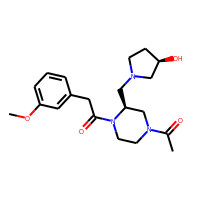
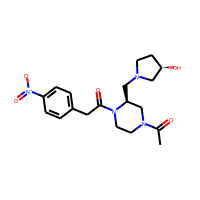
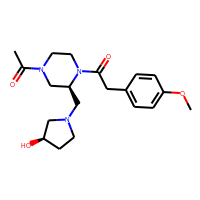
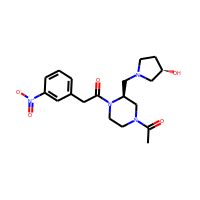
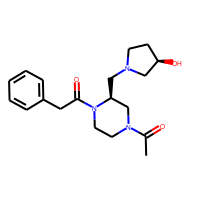
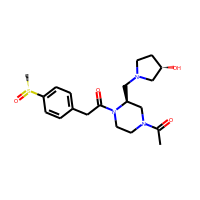
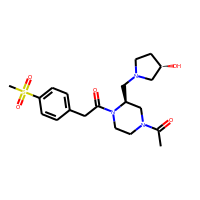
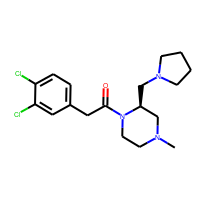
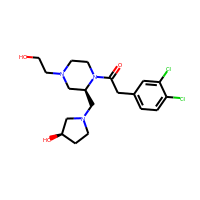

In [195]:
top9 = remained_df[remained_df['scaffold'] == scaffold_list[8]]
PandasTools.AddMoleculeColumnToFrame(top9, smilesCol='cano_smiles')
top9[['BBBP', 'cano_smiles', 'ROMol']]

In [175]:
top6 = remained_df[remained_df['scaffold'] == scaffold_list[5]]

In [16]:
test_df = remained_df.iloc[test_index,:] # test set
valid_df = remained_df.iloc[valid_index,:] # valid set
train_df = remained_df.drop(test_df.index).drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [176]:
PandasTools.AddMoleculeColumnToFrame(top6, smilesCol='cano_smiles')

,BBBP,cano_smiles,ROMol
105,0,C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@@]21C,
155,0,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2C(=O)CO,
260,0,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO,
323,0,C[C@]12CC[C@@H]3[C@H]4CCC(=O)C=C4CC[C@H]3[C@@H]1CC[C@@H]2O,
326,0,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4[C@H]3CC[C@@]21C,
374,0,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C,
398,0,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2O,
411,0,C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C@]2(C=O)[C@@H](C(=O)CO)CC[C@@H]12,
1106,1,CC12CCC(=O)C=C1CCC1C2CCC2(C)C1CCC2(O)C(=O)CO,
1226,1,C[C@]12C[C@H](O)[C@@]3(F)[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO,

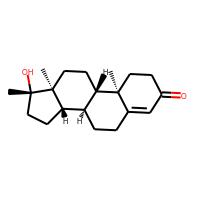
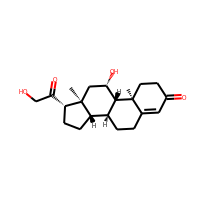
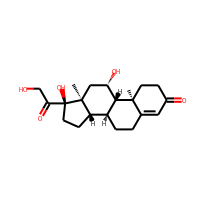
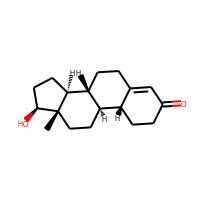
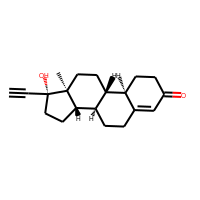
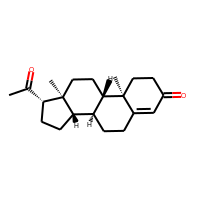
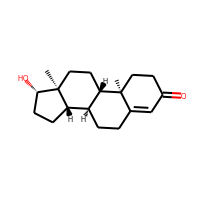
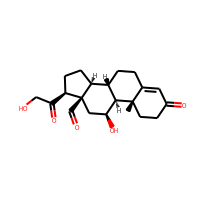
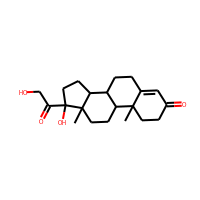
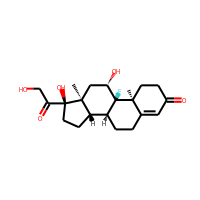
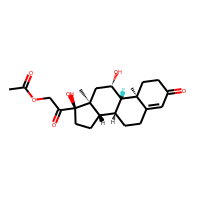
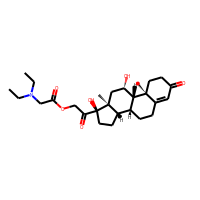
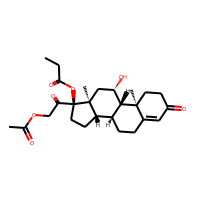
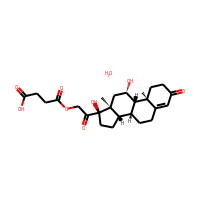
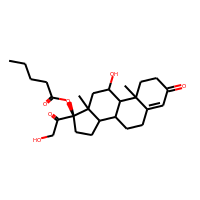
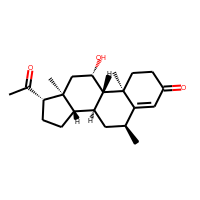
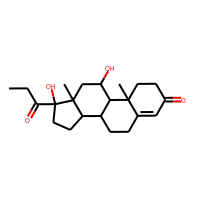
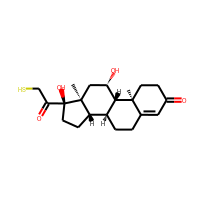
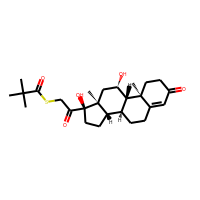
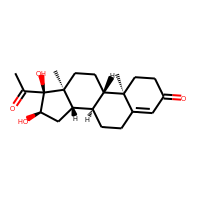
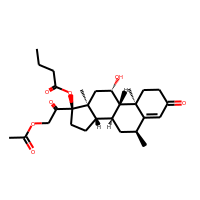
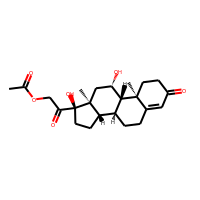
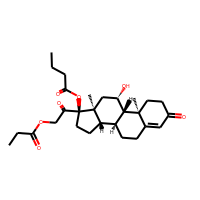
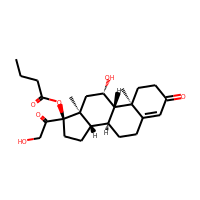

In [177]:
top6[['BBBP','cano_smiles', 'ROMol']]

In [185]:
PandasTools.AddMoleculeColumnToFrame(remained_df, smilesCol='cano_smiles')

RDKit WARNING: [23:31:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:26] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:26] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:31:26] WARNING: not r

,BBBP,smiles,cano_smiles,scaffold,ROMol
0,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,CC(C)NCC(O)COc1cccc2ccccc12.[Cl],c1ccc2ccccc2c1,
1,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,c1ccccc1,
2,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO3)=O,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,O=c1ccn2c3c(c(N4CCNCC4)ccc13)OCC2,
3,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,c1ccc(CN2CCCCC2)cc1,
4,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12,O=C(NC1C(=O)N2CCSC12)c1conc1-c1ccccc1,
5,1,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@H]2[C@H]3SCC(=C(N3C2=O)C(O)=O)CSc4nnnn4C)c5ccc(O)cc5)C(=O)C1=O,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3C(C(=O)O)=C(CSc4nnnn4C)CS[C@H]23)c2ccc(O)cc2)C(=O)C1=O,O=C1NCCN(C(=O)NC(C(=O)NC2C(=O)N3C=C(CSc4nnn[nH]4)CSC23)c2ccccc2)C1=O,
6,1,CN(C)[C@H]1[C@@H]2C[C@H]3C(=C(O)c4c(O)cccc4[C@@]3(C)O)C(=O)[C@]2(O)C(=O)\C(=C(/O)NCN5CCCC5)C1=O,CN(C)[C@@H]1C(=O)/C(=C(/O)NCN2CCCC2)C(=O)[C@@]2(O)C(=O)C3=C(O)c4c(O)cccc4[C@@](C)(O)[C@H]3C[C@@H]12,O=C1CC2CC3Cc4ccccc4C=C3C(=O)C2C(=O)C1=CNCN1CCCC1,
7,1,Cn1c2CCC(Cn3ccnc3C)C(=O)c2c4ccccc14,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O,O=C1c2c([nH]c3ccccc23)CCC1Cn1ccnc1,
8,1,COc1ccc(cc1)[C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O,COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O)cc1,O=C1CC(c2ccccc2)Sc2ccccc2N1,
9,1,NC(N)=NC(=O)c1nc(Cl)c(N)nc1N,NC(N)=NC(=O)c1nc(Cl)c(N)nc1N,c1cnccn1,

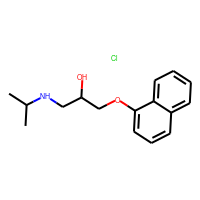
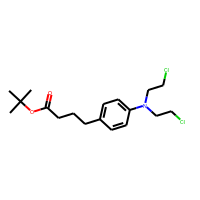
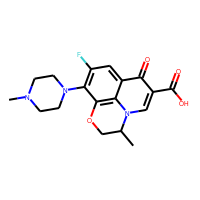
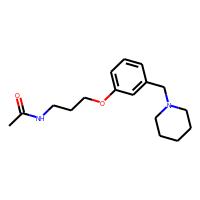
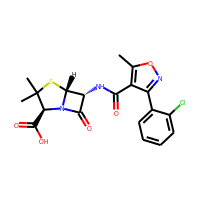
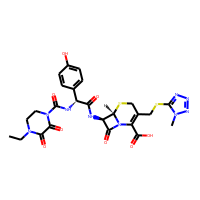
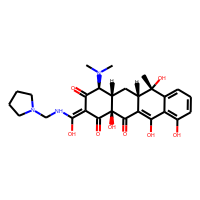
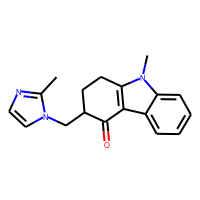
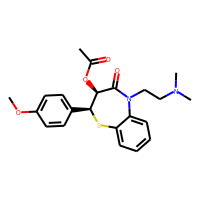
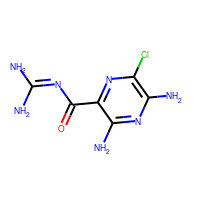
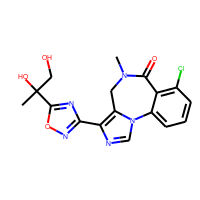
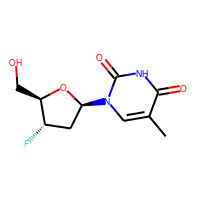
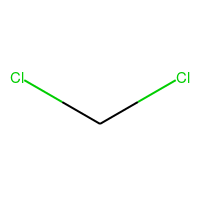
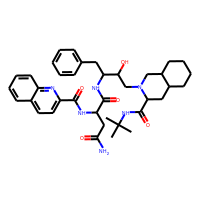
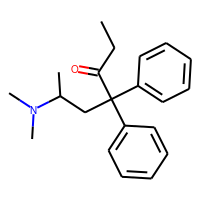
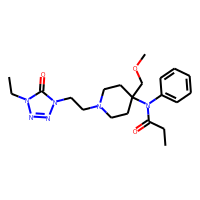
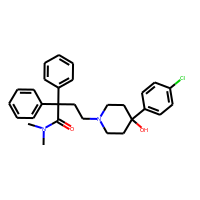
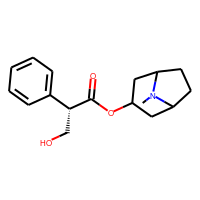

In [186]:
remained_df.head(18)

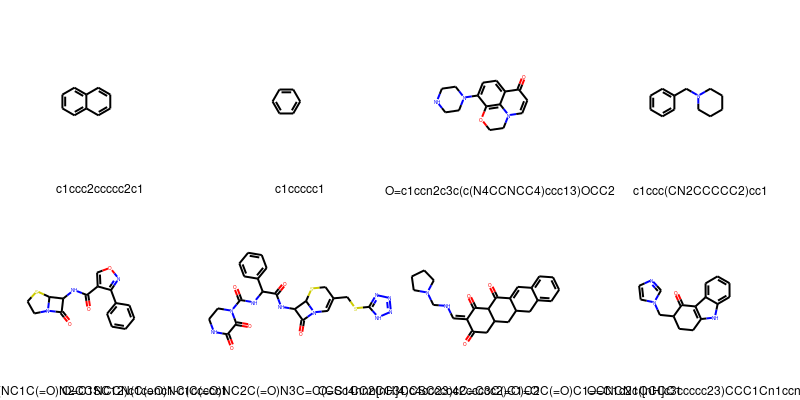

In [162]:
PandasTools.FrameToGridImage(remained_df.head(8), legendsCol='scaffold', molsPerRow=4)

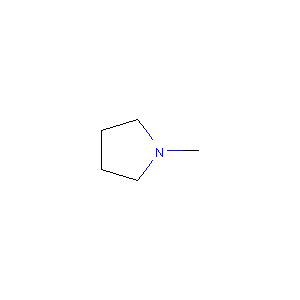

In [196]:
query = Chem.MolFromSmarts('C1CN(CC1)C')
Chem.Draw.MolToImage(query, kekulize=False)

,BBBP,cano_smiles,ROMol
6,1,CN(C)[C@@H]1C(=O)/C(=C(/O)NCN2CCCC2)C(=O)[C@@]2(O)C(=O)C3=C(O)c4c(O)cccc4[C@@](C)(O)[C@H]3C[C@@H]12,
17,1,CN1C2CCC1CC(OC(=O)[C@H](CO)c1ccccc1)C2,
49,1,O=C1CCCN1CCCCN1CCN(c2cc(C(F)(F)F)ccn2)CC1,
53,1,CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1,
60,1,CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C=O)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1,
72,1,CN1CC2c3ccccc3Oc3ccc(Cl)cc3C2C1,
124,0,CN1C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2,
141,1,CNC(=O)Oc1ccc2c(c1)[C@]1(C)CCN(C)[C@@H]1N2C,
165,1,OC(CCN1CCCC1)(c1ccccc1)C1CCCCC1,
201,0,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=O)[C@@H]3C=C4c5cccc6[nH]c(Br)c(c56)C[C@H]4N(C)C3)(C(C)C)C(=O)N12,

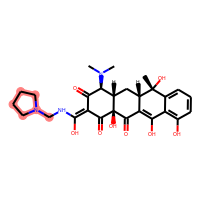
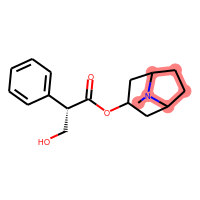
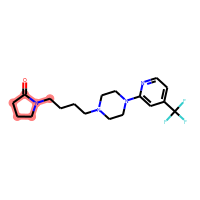
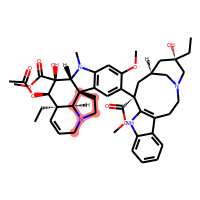
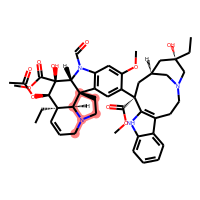
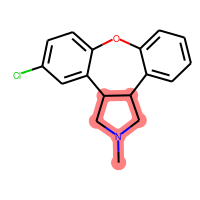
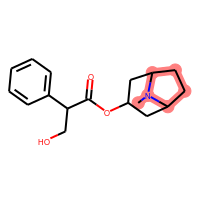
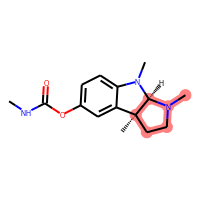
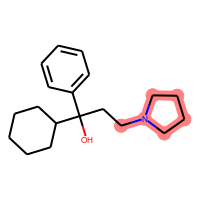
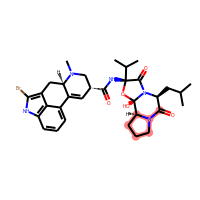
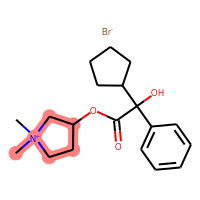
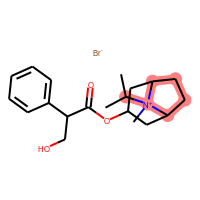
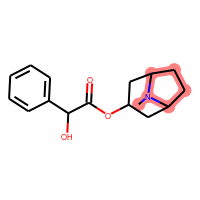
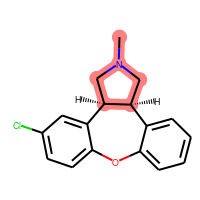
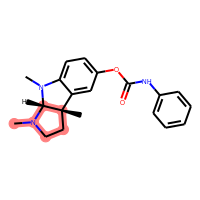
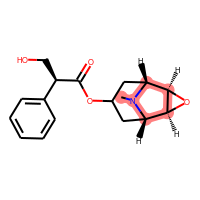
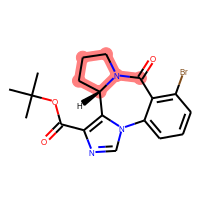
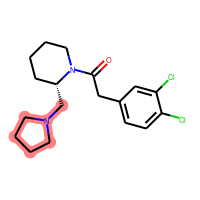
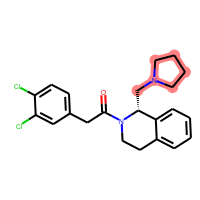
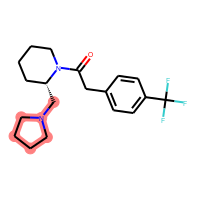
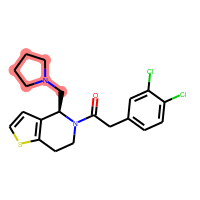
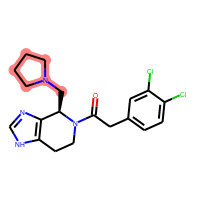
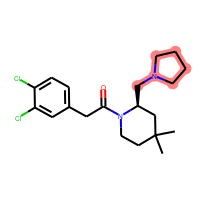
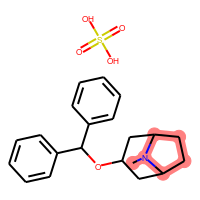
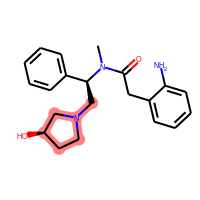
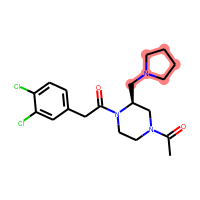
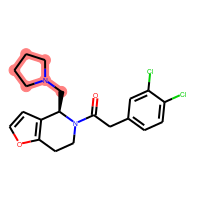
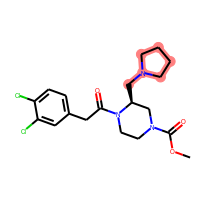
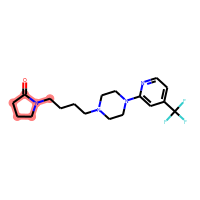
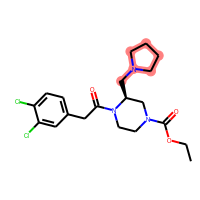
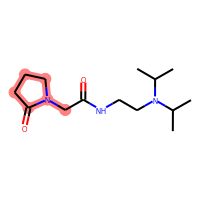
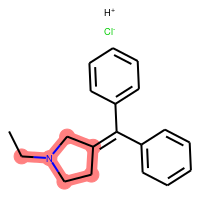
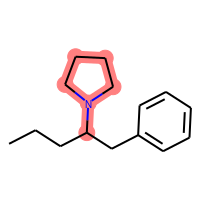
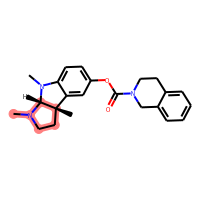
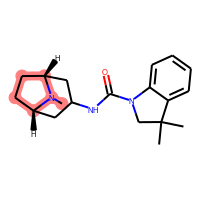
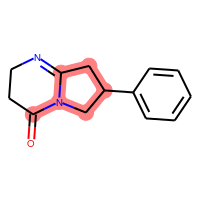
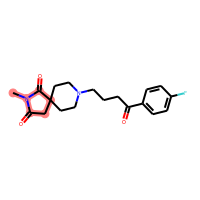
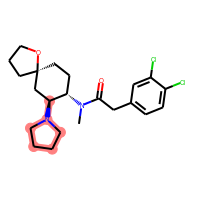
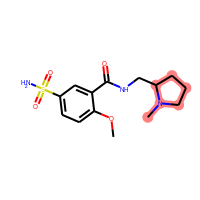
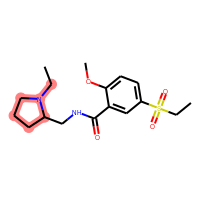
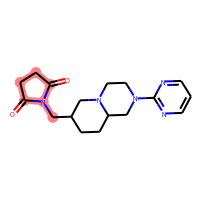
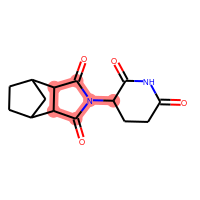
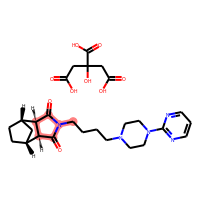
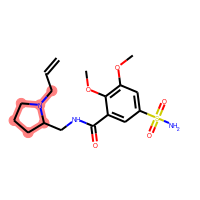
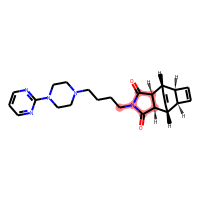
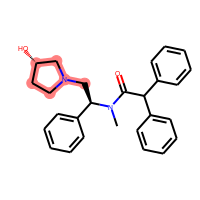
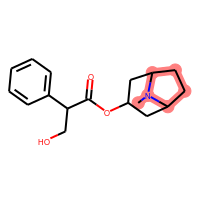
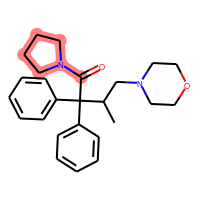
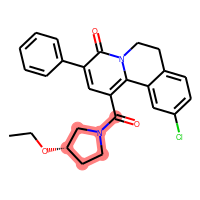
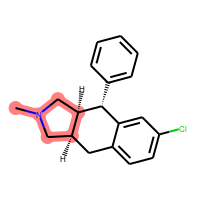
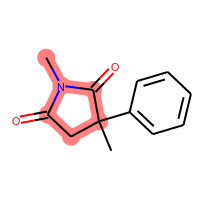
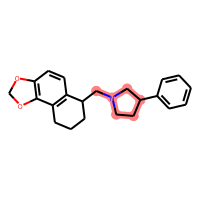
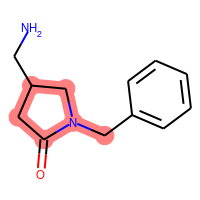
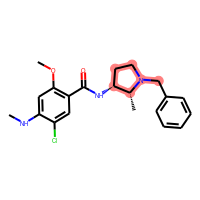
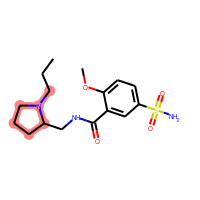
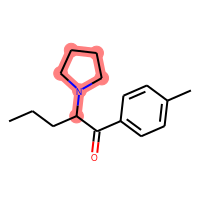
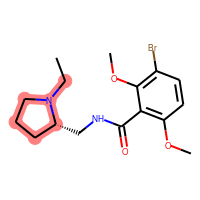
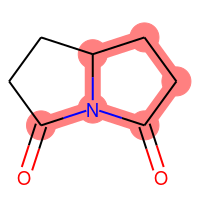
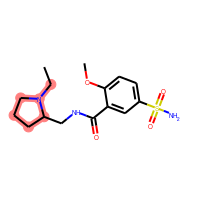
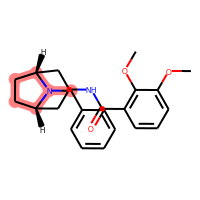

In [197]:
remained_df[remained_df['ROMol'] >= query][['BBBP','cano_smiles', 'ROMol']]

In [68]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

649206
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([150, 150])
attend.0.bias torch.Size([150])
attend.1.weight torch.Size([150, 150])
attend.1.bias torch.Size([150])
attend.2.weight torch.Size([150, 150])

In [69]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)            
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     test_prc = auc(recall, precision)
    test_precision = [precision_score(y_val_list[i],
                                     (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_roc, test_prc, test_precision, test_recall, test_loss


In [70]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_prc, train_precision, train_recall, train_loss = eval(model, train_df)
    valid_roc, valid_prc, valid_precision, valid_recall, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.87:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
        break
        
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc:[0.40824959175982917]
valid_roc:[0.3459789712986644]

EPOCH:	1
train_roc:[0.7326026881045095]
valid_roc:[0.8991190679170219]

EPOCH:	2
train_roc:[0.7633107231084872]
valid_roc:[0.9238420005683433]

EPOCH:	3
train_roc:[0.7793304861198342]
valid_roc:[0.9344984370559818]

EPOCH:	4
train_roc:[0.784112129966922]
valid_roc:[0.9305200341005967]

EPOCH:	5
train_roc:[0.7923878909684713]
valid_roc:[0.9326513213981245]

EPOCH:	6
train_roc:[0.8004312691035464]
valid_roc:[0.9342142654163114]

EPOCH:	7
train_roc:[0.8094753590419963]
valid_roc:[0.9340721795964763]

EPOCH:	8
train_roc:[0.8190742369049114]
valid_roc:[0.9319408922989484]

EPOCH:	9
train_roc:[0.8263765021144749]
valid_roc:[0.9343563512361466]

EPOCH:	10
train_roc:[0.8332035338944018]
valid_roc:[0.9329354930377948]

EPOCH:	11
train_roc:[0.8343152032826696]
valid_roc:[0.9386189258312021]

EPOCH:	12
train_roc:[0.8432127454674874]
valid_roc:[0.9354930377948282]

EPOCH:	13
train_roc:[0.8435728342335551]
valid_roc:[0.9394714

In [71]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     
best_model = torch.load('saved_models/model_BBBP_Fri_Jul_26_21-17-57_2019_90.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()

test_roc, test_prc, test_precision, test_recall, test_losses = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:59
test_roc:[0.7385034013605443]
test_roc_mean: 0.7385034013605443


In [109]:
valid_df[valid_df['BBBP'] == 0]

,BBBP,smiles,cano_smiles,scaffold
0,0,N[S](=O)(=O)c1cc(ccc1Cl)C2(O)NC(=O)c3ccccc23,NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl,O=C1NC(c2ccccc2)c2ccccc21
8,0,COc1cccc(OC)c1C(=O)N[C@H]2[C@H]3SC(C)(C)[C@@H]...,COc1cccc(OC)c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)...,O=C(NC1C(=O)N2CCSC12)c1ccccc1
16,0,CN1C(=O)N(C)c2ncn(CCNCC(O)c3ccc(O)c(O)c3)c2C1=O,Cn1c(=O)c2c(ncn2CCNCC(O)c2ccc(O)c(O)c2)n(C)c1=O,O=c1[nH]c(=O)c2c(ncn2CCNCCc2ccccc2)[nH]1
19,0,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](NC(=O)NC3=CN=C...,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](NC(=O)Nc3cnc(N...,O=C(Nc1cnc(Nc2ccccc2)[nH]c1=O)NC(C(=O)NC1C(=O)...
42,0,COc1cc(cc(OC)c1O)[C@H]2[C@@H]3C(COC3=O)[C@H](O...,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,O=C1OCC2C(OC3CCC4OCOCC4O3)c3cc4c(cc3C(c3ccccc3...
46,0,CCN(CC)CCOC(=O)C1(CCCCC1)C2CCCCC2,CCN(CC)CCOC(=O)C1(C2CCCCC2)CCCCC1,C1CCC(C2CCCCC2)CC1
50,0,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)C3=CCC=CC3)C...,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)C3=CCC=CC3)C...,O=C(CC1=CCC=CC1)NC1C(=O)N2CCSC12
87,0,NC(C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc3...,NC(C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3cn[nH]n...,O=C(Cc1ccccc1)NC1C(=O)N2C=C(CSc3cn[nH]n3)CSC12
98,0,CO[C@]1(NC(=O)C(C(O)=O)c2cscc2)[C@H]3SC(C)(C)[...,CO[C@@]1(NC(=O)C(C(=O)O)c2ccsc2)C(=O)N2[C@@H](...,O=C(Cc1ccsc1)NC1C(=O)N2CCSC12
104,0,OC(C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O)CSc3...,O=C(O)C1=C(CSc2nnnn2CS(=O)(=O)O)CS[C@@H]2[C@H]...,O=C(Cc1ccccc1)NC1C(=O)N2C=C(CSc3nnn[nH]3)CSC12


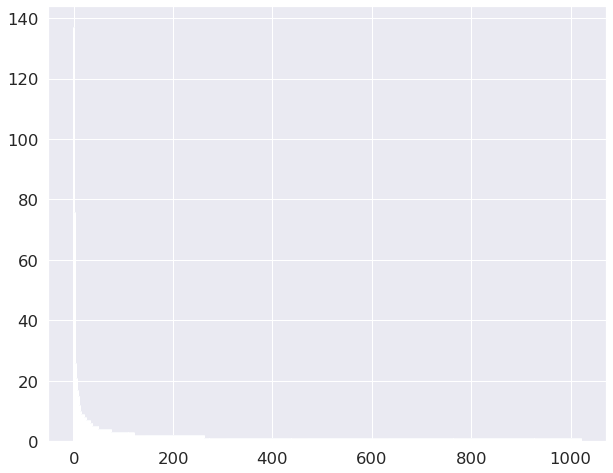

In [121]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

counts = Counter(remained_df['scaffold'])

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

plt.figure(figsize=(10, 8))
plt.bar(indexes, values)
plt.show()
plt.close()


In [130]:
sum(values[:3])

312

In [113]:
valid_df[valid_df['scaffold'] == 'O=C1CC2SCC(CSc3nnn[nH]3)=CN12']

,BBBP,smiles,cano_smiles,scaffold
190,0,[Na+].Cn1nnnc1SCC2=C(N3[C@H](SC2)[C@H](NC(=O)C...,Cn1nnnc1SCC1=C(C(=O)[O-])N2C(=O)[C@@H](NC(=O)C...,O=C1CC2SCC(CSc3nnn[nH]3)=CN12
191,0,Cn1nnnc1SCC2=C(N3[C@H](SC2)[C@H](NC(=O)CS\C=C/...,Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)CS/C...,O=C1CC2SCC(CSc3nnn[nH]3)=CN12
192,0,CO[C@]1(NC(=O)CSCC#N)[C@H]2SCC(=C(N2C1=O)C(O)=...,CO[C@@]1(NC(=O)CSCC#N)C(=O)N2C(C(=O)O)=C(CSc3n...,O=C1CC2SCC(CSc3nnn[nH]3)=CN12
193,0,CO[C@]1(NC(=O)CSC[C@@H](N)C(O)=O)[C@H]2SCC(=C(...,CO[C@@]1(NC(=O)CSC[C@@H](N)C(=O)O)C(=O)N2C(C(=...,O=C1CC2SCC(CSc3nnn[nH]3)=CN12


In [25]:
valid_df

,BBBP,smiles,cano_smiles,scaffold
0,0,N[S](=O)(=O)c1cc(ccc1Cl)C2(O)NC(=O)c3ccccc23,NS(=O)(=O)c1cc(C2(O)NC(=O)c3ccccc32)ccc1Cl,O=C1NC(c2ccccc2)c2ccccc21
1,1,C4=C(N3CCN(CCCCN2C(C1=C(C=CC=C1)NC2=O)=O)CC3)C...,CCCSc1ccccc1N1CCN(CCCCn2c(=O)[nH]c3ccccc3c2=O)CC1,O=c1[nH]c2ccccc2c(=O)n1CCCCN1CCN(c2ccccc2)CC1
2,1,Cc1nccc2c1[nH]c3ccccc23,Cc1nccc2c1[nH]c1ccccc12,c1ccc2c(c1)[nH]c1cnccc12
3,1,CCN(CC)C(=O)C1CN2CCc3cc(OC)c(OC)cc3C2CC1OC(C)=O,CCN(CC)C(=O)C1CN2CCc3cc(OC)c(OC)cc3C2CC1OC(C)=O,c1ccc2c(c1)CCN1CCCCC21
4,1,C1=C(C)C=CC2=C1C3N(CC2)CCC(C3)(CC)O,CCC1(O)CCN2CCc3ccc(C)cc3C2C1,c1ccc2c(c1)CCN1CCCCC21
5,1,C2=C(CN(C(=C(SC(=O)C1=CC=CC=C1)/CCO[P](=O)(O)O...,C/C(=C(\CCOP(=O)(O)O)SC(=O)c1ccccc1)N(C=O)Cc1c...,O=C(SC=CNCc1cncnc1)c1ccccc1
6,1,C1=C(SC2=C1C(=NCC3=NN=C([N]23)C4CCCCC4)C5=CC=C...,Clc1ccccc1C1=NCc2nnc(C3CCCCC3)n2-c2sc(Br)cc21,c1ccc(C2=NCc3nnc(C4CCCCC4)n3-c3sccc32)cc1
7,1,C1=CC=CC2=C1C(C(N2C3=CC=CC=C3)=O)(CC4=CC=NC=C4...,O=C1N(c2ccccc2)c2ccccc2C1(Cc1ccncc1)Cc1ccncc1,O=C1N(c2ccccc2)c2ccccc2C1(Cc1ccncc1)Cc1ccncc1
8,0,COc1cccc(OC)c1C(=O)N[C@H]2[C@H]3SC(C)(C)[C@@H]...,COc1cccc(OC)c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)...,O=C(NC1C(=O)N2CCSC12)c1ccccc1
9,1,CO[C@H]1[C@@H](C[C@@H]2CN3CCc4c([nH]c5cc(OC)cc...,COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]c5cc(OC)ccc5c...,O=C(C=Cc1ccccc1)OC1CCC2CC3c4[nH]c5ccccc5c4CCN3...


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LinearBn(nn.Module):
    def __init__(self, in_channel, out_channel, act=None):
        super(LinearBn, self).__init__()
        self.linear = nn.Linear(in_channel, out_channel)
        self.bn = nn.BatchNorm1d(out_channel, eps=1e-05, momentum=0.1)
        self.act = act

    def forward(self, x):
        x = self.linear(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.act is not None:
            x = self.act(x)
        return x

class Model(nn.Module):

    def __init__(self, fingerprint_dim, output_units_num):
        super(Model, self).__init__()
        self.encoder = nn.Sequential(
            LinearBn(fingerprint_dim, fingerprint_dim // 2),
            nn.ReLU(inplace=True),
            LinearBn(fingerprint_dim // 2, fingerprint_dim * 2),
            nn.ReLU(inplace=True),
            LinearBn(fingerprint_dim * 2, output_units_num),
            nn.ReLU(inplace=True),
        )

    def forward(self, fingerprints):            
        mol_prediction = self.encoder(fingerprints)
            
        return mol_prediction

In [12]:
import rdkit.Chem as Chem
from rdkit.Chem import AllChem

def smiles_to_fps(data, fp_length, fp_radius=2):
    return stringlist2intarray(np.array([smile_to_fp(s, fp_length, fp_radius) for s in data]))

def smile_to_fp(s, fp_length, fp_radius):
    m = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(
        m, fp_radius, nBits=fp_length)).ToBitString()

def stringlist2intarray(A):
    return np.array([list(s) for s in A], dtype=int)

In [13]:
loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Model(1024, 2)
model.cuda()
optimizer = optim.Adam(model.parameters(), 0.001, weight_decay=0)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1584646
encoder.0.linear.weight torch.Size([512, 1024])
encoder.0.linear.bias torch.Size([512])
encoder.0.bn.weight torch.Size([512])
encoder.0.bn.bias torch.Size([512])
encoder.2.linear.weight torch.Size([2048, 512])
encoder.2.linear.bias torch.Size([2048])
encoder.2.bn.weight torch.Size([2048])
encoder.2.bn.bias torch.Size([2048])
encoder.4.linear.weight torch.Size([2, 2048])
encoder.4.linear.bias torch.Size([2])
encoder.4.bn.weight torch.Size([2])
encoder.4.bn.bias torch.Size([2])


In [14]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        fingerprints = smiles_to_fps(batch_df['cano_smiles'].values, 1024)
        y_pred = model(torch.Tensor(fingerprints))
#         print(y_pred)
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = y_pred[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        loss.backward()
        optimizer.step()
        
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        smiles_list = batch_df.cano_smiles.values
        fingerprints = smiles_to_fps(batch_df['cano_smiles'].values, 1024)
        y_pred = model(torch.Tensor(fingerprints))                
        for i,task in enumerate(tasks):
            y_pred = y_pred[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
                
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_roc, test_loss


In [17]:
for epoch in range(20):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_loss"+":"+str(train_loss)+'\n'\
        +"valid_loss"+":"+str(valid_loss)+'\n'\
        )
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc:[0.487418623594264]
valid_roc:[0.4745786128764852]
train_loss:0.692767
valid_loss:0.6932083

EPOCH:	1
train_roc:[0.9191708394109117]
valid_roc:[0.8102376347057199]
train_loss:0.6380522
valid_loss:0.6105648

EPOCH:	2
train_roc:[0.9704687575640856]
valid_roc:[0.8552777010223819]
train_loss:0.5140316
valid_loss:0.5092069

EPOCH:	3
train_roc:[0.984421404020568]
valid_roc:[0.8515473887814313]
train_loss:0.41272482
valid_loss:0.44455063

EPOCH:	4
train_roc:[0.9889424908494298]
valid_roc:[0.8582481348438795]
train_loss:0.36879498
valid_loss:0.41956353

EPOCH:	5
train_roc:[0.990973612259975]
valid_roc:[0.8577645758496822]
train_loss:0.36664295
valid_loss:0.43544564

EPOCH:	6
train_roc:[0.9918597284401198]
valid_roc:[0.8517546283503731]
train_loss:0.33434194
valid_loss:0.43089876

EPOCH:	7
train_roc:[0.9923659302009864]
valid_roc:[0.8498894722298979]
train_loss:0.33237296
valid_loss:0.43001518

EPOCH:	8
train_roc:[0.9923890828802775]
valid_roc:[0.8607350096711799]
train_loss:

In [19]:
test_roc, test_losses = eval(model, test_df)

print("test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

test_roc:[0.88003479191757]
test_roc_mean: 0.88003479191757


RDKit WARNING: [09:40:32] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [09:40:32] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [09:40:32] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [09:40:32] WARNING: not removing hydrogen atom without neighbors
